In [2]:
pip install cpuinfo

ERROR: Could not find a version that satisfies the requirement cpuinfo (from versions: none)
ERROR: No matching distribution found for cpuinfo
Note: you may need to restart the kernel to use updated packages.


In [5]:
import platform
import psutil
import os
#import cpuinfo

def get_hardware_details():
    # CPU details
    cpu_info = cpuinfo.get_cpu_info()
    cpu_name = cpu_info['brand_raw'] if 'brand_raw' in cpu_info else 'Unknown'
    cpu_architecture = platform.architecture()[0]
    cpu_cores_physical = psutil.cpu_count(logical=False)
    cpu_cores_logical = psutil.cpu_count(logical=True)

    # Memory details
    memory_info = psutil.virtual_memory()
    total_memory_gb = memory_info.total / (1024 ** 3)

    # Disk details
    disk_info = psutil.disk_usage('/')
    total_disk_space_gb = disk_info.total / (1024 ** 3)

    # GPU details (requires optional library `GPUtil`)
    #try:
        #import GPUtil
        #gpus = GPUtil.getGPUs()
        #gpu_details = [f"{gpu.name}, {gpu.memoryTotal} MB VRAM" for gpu in gpus]
    #except ImportError:
        gpu_details = ["GPUtil library not installed"]

    # OS details
    os_name = platform.system()
    os_version = platform.version()
    os_release = platform.release()

    # Combine all details into a dictionary
    hardware_details = {
        "CPU Name": cpu_name,
        "CPU Architecture": cpu_architecture,
        "Physical CPU Cores": cpu_cores_physical,
        "Logical CPU Cores": cpu_cores_logical,
        "Total RAM (GB)": round(total_memory_gb, 2),
        "Total Disk Space (GB)": round(total_disk_space_gb, 2),
        "GPU Details": gpu_details,
        "Operating System": f"{os_name} {os_release} ({os_version})",
    }

    return hardware_details

def print_hardware_details(hardware_details):
    print("\nMachine Hardware Details:")
    for key, value in hardware_details.items():
        if isinstance(value, list):
            print(f"{key}: {', '.join(value)}")
        else:
            print(f"{key}: {value}")

if __name__ == "__main__":
    details = get_hardware_details()
    print_hardware_details(details)


IndentationError: expected an indented block after 'try' statement on line 23 (2737038292.py, line 27)

## code for EASE

In [2]:
pip install --upgrade jax jaxlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 MB 84.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 104.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install numpy==1.21.6

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 89.2 MB/s eta 0:00:00:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
contourpy 1.3.1 requires numpy>=1.23, but you have numpy 1.21.6 which is incompatible.
cupy-cuda12x 13.3.0 requires numpy<2.3,>=1.22, but you have numpy 1.21.6 which is incompatible.
geopandas 1.0.1 requires numpy>=1.22, but you have numpy 1.21.6 which is incompatible.
jax 0.4.38 requires numpy>=1.24, but you have numpy 1.21.6 which is incompatible.
jaxlib 0.4.38 requires numpy>=1.24, but you have numpy 1.21.6 which is incompatible.
numba 0.58.1 requires numpy<1.27,>=1.22, but you have numpy 1.21.6 which is incompatible.
pywavelets 1.7.0 requires

In [1]:
#model.py
import psutil
import jax
import functools
from jax import scipy as sp
from jax import numpy as jnp
#from neural_tangents import stax
import torch
from torch import nn
import numpy as np

from scipy.sparse import csr_matrix

def make_kernelized_rr_forward(hyper_params):
    _, _, kernel_fn = FullyConnectedNetwork(
        depth=hyper_params['depth'],
        num_classes=hyper_params['num_items']
    )
    # NOTE: Un-comment this if the dataset size is very big (didn't need it for experiments in the paper)
    # kernel_fn = nt.batch(kernel_fn, batch_size=128)
    kernel_fn = functools.partial(kernel_fn, get='ntk') #NN

    @jax.jit
    #this does the predictions!
    def kernelized_rr_forward(X_train, X_predict, reg=0.1):
        K_train = kernel_fn(X_train, X_train) # user * user
        K_predict = kernel_fn(X_predict, X_train) # user * user
        K_reg = (K_train + jnp.abs(reg) * jnp.trace(K_train) * jnp.eye(K_train.shape[0]) / K_train.shape[0]) # user * user
        return jnp.dot(K_predict, sp.linalg.solve(K_reg, X_train, sym_pos=True))
        # sp.linalg.solve(K_reg, X_train, sym_pos=True)) -> user * item

    return kernelized_rr_forward, kernel_fn

def FullyConnectedNetwork(
    depth,
    W_std = 2 ** 0.5,
    b_std = 0.1,
    num_classes = 10,
    parameterization = 'ntk'
):
    activation_fn = stax.Relu()
    dense = functools.partial(stax.Dense, W_std=W_std, b_std=b_std, parameterization=parameterization)

    layers = [stax.Flatten()]
    # NOTE: setting width = 1024 doesn't matter as the NTK parameterization will stretch this till \infty
    for _ in range(depth): layers += [dense(1024), activation_fn]
    layers += [stax.Dense(num_classes, W_std=W_std, b_std=b_std, parameterization=parameterization)]

    return stax.serial(*layers)
from scipy.sparse.linalg import inv
class EASE(nn.Module):
    def __init__(self, adj_mat, item_adj, mode, n,l,A,B, device='cuda:0'):
        super(EASE, self).__init__()
        self.mode= mode
        self.device= device
        GRAM_L,GRAM_R= item_adj
        self.adj_mat = adj_mat#.to(device)
        print("done")
        if self.mode in ["ease","both","both_R","both_RT"] :
          self.GRAM_L = GRAM_L
          print("left Gram", self.GRAM_L.shape)
        if self.mode in  ["ease_R","both","both_R","both_RT"]:
          self.GRAM_R = GRAM_R#.to(device)
          print("right Gram", self.GRAM_R.shape)
        if self.mode=="ensemble_l":
          self.n,self.l,self.A,self.B=n,l,A,B

    def forward(self, lambda_): #con pytorch las matrices no cambian...
        if self.mode=="ensemble_l":
            diagIndices = np.diag_indices(self.A.shape[1])
            G_X= self.A
            G_X[diagIndices] +=  lambda_
            A_= torch.inverse(G_X)
            B= torch.mm(A_, self.B)
            #diagonal_matrix = torch.diag(torch.diag(A_B_)/torch.diag(A_))
            #right_side= A_B_ - diagonal_matrix
            #B = torch.mm(A_, right_side)
            #l=[]
            for i in range(self.n):
              #diagIndices = np.diag_indices(self.adj_mat.shape[1])
              #R=self.l[i].to(device)
              #G_X= torch.mm(R.T, R)
              #G_X[diagIndices] +=  lambda_
              #A_= torch.inverse(G_X)
              #B= torch.mm(A_, R.T)
              #B= torch.mm(B, self.adj_mat)
              #l.append(torch.mm(R, B))
              if i==0:
                rating= torch.mm(self.l[i], B)
                #l.append(torch.mm(R, B))
              else:
                rating+= torch.mm(self.l[i], B)
                #l.append(torch.mm(self.l[i], B))
            #stacked_matrices = torch.stack(l)
            #rating= torch.max(stacked_matrices, dim=0).values
            rating= rating/self.n
        if self.mode in ["both","both_R","both_RT"] :
          P_L=self.GRAM_L.clone()
          print("clone L")
          diagIndices = np.diag_indices(P_L.shape[0])
          P_L[diagIndices] += lambda_ if self.mode=="left" else lambda_[0]
          print("inverse L")
          P_L = torch.inverse(P_L)#.cpu() #IXI
          print("inverse L")
          if self.mode=="both" or self.mode=="both_R":
            B_L= torch.mm(self.GRAM_L,self.adj_mat.T) #torch.mm(P_L,self.GRAM_L) 
            B_L=torch.mm(B_L,self.adj_mat)

          if self.mode=="both_RT":
            #print("to cpu")
            #P_L= P_L.cpu()
            #print("to csr_matrix")
            #P_L= P_L.numpy()
            # Get memory usage details
            #memory_info = psutil.virtual_memory()
            # Print total, used, and available memory
            #print(f"Total memory: {memory_info.total / (1024 ** 3):.2f} GB")
            #print(f"Used memory: {memory_info.used / (1024 ** 3):.2f} GB")
            #print(f"Available memory: {memory_info.available / (1024 ** 3):.2f} GB")
            
            print(type(self.GRAM_L), type(P_L))
            #self.GRAM_L=convert_sp_mat_to_sp_tensor(self.GRAM_L)
            print("B_L")
            B_L= torch.mm(self.GRAM_L,P_L)
            #chunk_size = 1000  # Adjust based on your system’s capacity
            #B_L = np.zeros(P_L.shape)
            #print(self.GRAM_L.shape, P_L.shape)
            #for i in range(0, P_L.shape[0], chunk_size):
                #print("dot: ",i+chunk_size)
                #B_L[i:i+chunk_size] = self.GRAM_L[i:i+chunk_size] @ P_L

            #B_L= self.adj_mat @ P_L#self.GRAM_L @ P_L#torch.mm(convert_sp_mat_to_sp_tensor(self.GRAM_L),P_L)
            #print("R INV")
            #B_L= self.adj_mat.T @ P_L
            #print("R.T R INV")
            print("free gpu")
            torch.cuda.empty_cache()
            
            
          P_R=self.GRAM_R.clone() #copy()
          print("clone R")
          diagIndices = np.diag_indices(P_R.shape[0])
          P_R[diagIndices] += lambda_ if self.mode=="right" else lambda_[1]
          print("inverse R") 
          P_R = torch.inverse(P_R)# uxu
          print("inverse R")
          if self.mode=="both":
            B_R= torch.mm(self.adj_mat.T, P_R)
            B= torch.mm(B_L,B_R)
            rating= torch.mm(self.adj_mat,B)
            rating= torch.mm(rating,self.adj_mat)

          if self.mode=="both_R":
            B_R= torch.mm(self.GRAM_R, P_R)
            B= torch.mm(B_L,self.adj_mat.T)
            rating= torch.mm(B,B_R).T

          if self.mode=="both_RT":
            B_R= torch.mm(P_R,self.GRAM_R)
            B=torch.mm(B_R,self.adj_mat)
            rating=torch.mm(B,B_L)

        if self.mode=="ease":
          """
          #residual
          n=30
          for i in range(n):
            if i==0:
              Y= self.adj_mat
            else:
              Y= residual
            G_R= self.adj_mat.T@self.adj_mat
            diagIndices = np.diag_indices(G_R.shape[0])
            G_R[diagIndices] +=  lambda_ if self.mode=="ease" else lambda_[0]
            P = torch.inverse(G_R)
            actual_W= P @ self.adj_mat.T @ Y
            actual_W[diagIndices] = 0
            if i==0:
                acc_W= actual_W
            else:
              acc_W+= actual_W
            rating= self.adj_mat @ acc_W
            residual= self.adj_mat-rating
            print("RMSE: ", torch.sqrt(torch.mean((self.adj_mat - rating) ** 2)))
          """
          #EASE
          diagIndices = np.diag_indices(self.GRAM_L.shape[0])
          self.GRAM_L[diagIndices] +=  lambda_ if self.mode=="ease" else lambda_[0]
          P= torch.inverse(self.GRAM_L)
          B_L = P / (-torch.diag(P))
          B_L[diagIndices] = 0
          rating = torch.mm(self.adj_mat, B_L)
          #print("RMSE: ", torch.sqrt(torch.mean((self.adj_mat - rating) ** 2)))
          #X_R=torch.cat((self.adj_mat, rating), dim=1)
          #G_R= X_R.T@X_R
          #diagIndices = np.diag_indices(G_R.shape[0])
          #G_R[diagIndices] +=  lambda_
          #inv_G_R= torch.inverse(G_R)
          #W= inv_G_R @ X_R.T @ (self.adj_mat-rating)
          #rating_2= torch.mm(X_R, W)
        if self.mode=="ease_R":
          diagIndices = np.diag_indices(self.GRAM_R.shape[0])
          self.GRAM_R[diagIndices] += lambda_ if self.mode=="ease_R" else lambda_[1]
          print(self.GRAM_R.shape, "inverse:")
          P = torch.inverse(self.GRAM_R) #np.linalg.inv(self.GRAM_R.toarray()) #
          B_R = P / (-torch.diag(P))
          B_R[diagIndices] = 0
          rating = torch.mm(B_R,self.adj_mat)
        #if self.mode=="ease_both":
          #B= B_R @ self.adj_mat @ B_L
          #rating= B
        """
        exp = {"d": (5,5),
                        "n": (100,100),
                        "m": (100,100),
                        "c": (1E-5,1E-5),
                        "graph_c":None, #equally important
                        "graph_L": [None, None], #it was calculated before the inputation
                        "graph_a": [False,False],
                        "train_x": self.adj_mat, #resultado
                        "train_x_B": (self.adj_mat).T, #resultado_B
                        "train_y": self.adj_mat}

        encoding= BLS( exp)
        encoding.train_AB()
        rating=np.asarray(encoding.OutputOfTrain)
        """
        return rating

class SVD_AE(nn.Module):
    def __init__(self, adj_mat, norm_adj, user_sv, item_sv, device='cuda:0'):
        super(SVD_AE, self).__init__()
        self.adj_mat = adj_mat.to(device)
        self.norm_adj = norm_adj.to(device)
        self.user_sv = user_sv.to(device) # (K, M)
        self.item_sv = item_sv.to(device) # (K, N)

    def forward(self, lambda_mat):
        A = self.item_sv @ (torch.diag(1/lambda_mat)) @ self.user_sv.T
        rating = torch.mm(self.norm_adj, A @ self.adj_mat.to_dense())
        # torch.inverse(torch.diag(lambda_mat))
        return rating

In [2]:
import torch

def introduce_ones_in_zeros(matrix, percentage):
  """Introduces ones in a given percentage of zero elements in each row of a PyTorch matrix.

  Args:
    matrix: The input PyTorch matrix.
    percentage: The percentage of zero elements to replace with ones (between 0 and 1).

  Returns:
    A new matrix with the specified percentage of zero elements replaced with ones per row.
  """

  # Create a copy to avoid modifying the original matrix
  new_matrix = matrix.clone()

  # Iterate over rows
  for i in range(new_matrix.shape[0]):
    # Find zero indices in the current row
    row_zero_indices = torch.nonzero(new_matrix[i] == 0)

    if len(row_zero_indices) > 0:  # Avoid if the row is all ones
      # Number of elements to replace with ones
      num_to_replace = int(len(row_zero_indices) * 0.1)

      # Randomly select indices to replace
      indices_to_replace = torch.randperm(len(row_zero_indices))[:num_to_replace]

      # Replace the selected elements with ones
      for index in indices_to_replace:
        new_matrix[i, row_zero_indices[index]] = 1

  return new_matrix

# Example usage
matrix = torch.tensor([[1, 0, 0, 2],
                      [0, 0, 3, 0],
                      [4, 5, 0, 0]])
percentage = 0.5  # Introduce ones in 50% of zero elements

modified_matrix = introduce_ones_in_zeros(matrix, percentage)
print("Original Matrix:")
print(matrix)
print("\nModified Matrix:")
print(modified_matrix)

Original Matrix:
tensor([[1, 0, 0, 2],
        [0, 0, 3, 0],
        [4, 5, 0, 0]])

Modified Matrix:
tensor([[1, 0, 0, 2],
        [0, 0, 3, 0],
        [4, 5, 0, 0]])


In [3]:
# prompt: en una matriz pytorch marca un cierto % de los valores no zero como zero por fila

import torch

def zero_out_percentage(matrix, percentage):
  """Zeros out a given percentage of non-zero elements in each row of a PyTorch matrix.

  Args:
    matrix: The input PyTorch matrix.
    percentage: The percentage of non-zero elements to zero out (between 0 and 1).

  Returns:
    A new matrix with the specified percentage of non-zero elements zeroed out per row.
  """

  # Create a copy to avoid modifying the original matrix
  new_matrix = matrix.clone()

  # Iterate over rows
  for i in range(new_matrix.shape[0]):
    # Find non-zero indices in the current row
    row_nonzero_indices = torch.nonzero(new_matrix[i])

    if len(row_nonzero_indices)>0: #avoid if the row is all zeros
      # Number of elements to zero out
      num_to_zero = int(len(row_nonzero_indices) * percentage)

      # Randomly select indices to zero out
      indices_to_zero = torch.randperm(len(row_nonzero_indices))[:num_to_zero]

      # Zero out the selected elements
      for index in indices_to_zero:
        new_matrix[i, row_nonzero_indices[index]] = 0

  return new_matrix

In [4]:
#import dask.array as da
#utils.py

import numpy as np
import random
from collections import defaultdict
import torch
import scipy.sparse as sp
import time
import os

def get_common_path(hyper_params):
    ret = "{}_{}_".format(
        hyper_params['dataset'], hyper_params['model']
    )
    if hyper_params['model'] == 'svd-ae': ret += "k_{}_".format(hyper_params['k'])
    else:
        if hyper_params['grid_search_lamda']: ret += "grid_search_lamda_"
        else: ret += "lamda_{}_".format(hyper_params['lamda'])

    ret += "seed_{}".format(hyper_params['seed'])
    return ret

def get_item_count_map(data):
    item_count = defaultdict(int)
    for u, i, r in data.data['train']: item_count[i] += 1
    return item_count

def get_item_propensity(hyper_params, data, A = 0.55, B = 1.5):
    item_freq_map = get_item_count_map(data)
    item_freq = [ item_freq_map[i] for i in range(hyper_params['num_items']) ]
    num_instances = hyper_params['num_interactions']

    C = (np.log(num_instances)-1)*np.power(B+1, A)
    wts = 1.0 + C*np.power(np.array(item_freq)+B, -A)
    return np.ravel(wts)

def file_write(log_file, s, dont_print=False):
    if dont_print == False: print(s)
    if log_file is None: return
    f = open(log_file, 'a')
    f.write(s+'\n')
    f.close()

def log_end_epoch(hyper_params,best_lamda, metrics, step, time_elpased, metrics_on = '(TEST)', dont_print = False):
    string2 = ""
    for m in metrics: string2 += " | " + m + ' = ' + str("{:2.4f}".format(metrics[m]))
    string2 += ' ' + metrics_on

    if hyper_params['model'] == 'svd-ae':
        ss  = '| end of step {:4d} | time = {:5.2f}'.format(step, time_elpased)
    else:
        ss  = '| end of step {:4d} | time = {:5.2f} | best lambda = {}'.format(step, time_elpased, best_lamda)

    ss += string2
    file_write(hyper_params['log_file'], ss, dont_print = dont_print)

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.manual_seed(seed)

def convert_sp_mat_to_sp_tensor(X):
    coo = X.tocoo().astype(np.float32)
    row = torch.Tensor(coo.row).long()
    col = torch.Tensor(coo.col).long()
    index = torch.stack([row, col])
    data = torch.FloatTensor(coo.data)
    return torch.sparse.FloatTensor(index, data, torch.Size(coo.shape))

def get_file_name(dataset, k, path):
    ut = f"{dataset}-{k}-ut.npy"
    s = f"{dataset}-{k}-s.npy"
    vt = f"{dataset}-{k}-vt.npy"
    file_list = [ut, s, vt]
    file_list = [os.path.join(path, file) for file in file_list]
    return file_list

def preprocess_ease(adj_mat,  mode, ensamble_params ,device):

    start = time.time()
    adj_mat =  adj_mat
    GRAM_L,GRAM_R=None,None
    if mode in ["ease","both","both_R","both_RT"] :
      GRAM_L = adj_mat.T @ adj_mat 
      #GRAM_L = convert_sp_mat_to_sp_tensor(GRAM_L)
      print("GRAM_L")
      GRAM_L = convert_sp_mat_to_sp_tensor(GRAM_L).to_dense()
    if mode in ["ease_R","both","both_R","both_RT"] :
      print("compute: ")
      #adj_mat_ = np.array(convert_sp_mat_to_sp_tensor(adj_mat).to_dense())
      #A=da.from_array(adj_mat_,chunks="500 MiB" )
      #A_T=da.from_array(adj_mat.T,chunks=(1000, 1000))
      #print(A.shape,adj_mat_.shape)
      #GRAM_R= da.tensordot(A, A.T, axes=(1, 0)).compute() #da.matmul(A, A.T).compute()
      #print(GRAM_R.shape)
      GRAM_R = adj_mat @ adj_mat.T 
      #GRAM_R = convert_sp_mat_to_sp_tensor(GRAM_R)
      print("GRAM_R")
      GRAM_R = convert_sp_mat_to_sp_tensor(GRAM_R).to_dense()
      #print("done")
    
    adj_mat = convert_sp_mat_to_sp_tensor(adj_mat).to_dense()
    #print("done adj")

    n,l,A,B=None,None, None,None
    if mode=="ensemble_l":
          n,p=ensamble_params
          l=[]
          #identity_matrix = torch.eye(adj_mat.shape[1])
          for i in range(n):
            #print("iteration: ", i)
                    # Crear la matriz identidad
            # Crear una matriz aleatoria de dimensiones n x n
            #matriz2 = torch.rand(adj_mat.shape[1], int(adj_mat.shape[1]/2)) #
            # Concatenar horizontalmente la matriz identidad y la matriz aleatoria
            #matriz2 = torch.cat([identity_matrix, random_matrix], dim=1)
            #matriz2 = torch.rand(adj_mat.shape[1],adj_mat.shape[1]*2)  # Matriz de 2 filas y 4 columnas
            # Multiplicar las matrices
            #R = torch.mm(adj_mat, matriz2)
            #print("R.shape", R.shape)
            #introduce_ones_in_zeros(adj_mat, p)
            R=zero_out_percentage(adj_mat, p)
            if i==0:
              X=torch.mm(R.T,R)
              Y=  torch.mm(R.T,adj_mat)
            else:
              X+=torch.mm(R.T,R)
              Y+= torch.mm(R.T,adj_mat)
            l.append(R.clone())
          A= X.T@X
          B= X.T@Y
    end = time.time()
    #print('Pre-processing time: ', end-start)
    return adj_mat, (GRAM_L,GRAM_R),n,l,A,B

def preprocess_svd(LOAD, dataset, adj_mat, k, path, device):
    # start = time.time()
    file_list = get_file_name(dataset, k, path)
    rowsum = np.array(adj_mat.sum(axis=1))
    rowsum = np.where(rowsum == 0.0, 1.0, rowsum) # Do not divide by zero
    d_inv = np.power(rowsum, -0.5).flatten()
    d_inv[np.isinf(d_inv)] = 0.
    d_mat = sp.diags(d_inv)
    norm_adj = d_mat.dot(adj_mat)
    colsum = np.array(adj_mat.sum(axis=0))
    colsum = np.where(colsum == 0.0, 1.0, colsum) # Do not divide by zero
    d_inv = np.power(colsum, -0.5).flatten()
    d_inv[np.isinf(d_inv)] = 0.
    d_mat_i = sp.diags(d_inv)
    d_mat_i_inv = sp.diags(1/d_inv)
    norm_adj = norm_adj.dot(d_mat_i)
    norm_adj = norm_adj.tocsc()
    adj_mat = convert_sp_mat_to_sp_tensor(adj_mat)
    norm_adj = convert_sp_mat_to_sp_tensor(norm_adj)

    if LOAD:
        cond = os.path.isfile(file_list[0]) & os.path.isfile(file_list[1]) & os.path.isfile(file_list[2])
        if cond:
            print("Load pre-calculated eigenvectors and eigenvalues!")
            ut, s, vt = np.load(file_list[0]), np.load(file_list[1]), np.load(file_list[2])
        else:
            print("Saved numpy files don't exist!")
            exit()
    else:
        start = time.time()
        ut, s, vt = torch.svd_lowrank(norm_adj, q=k, niter=2, M=None)
        end = time.time()
        if not os.path.isdir(path):
	        os.makedirs(path)
        np.save(file_list[0], ut.cpu().numpy())
        np.save(file_list[1], s.cpu().numpy())
        np.save(file_list[2], vt.cpu().numpy())

    norm_adj = norm_adj.to_dense()
    ut = torch.FloatTensor(ut)
    s = torch.FloatTensor(s)
    vt = torch.FloatTensor(vt)
    # end = time.time()
    print('Pre-processing time: ', end-start)
    return adj_mat, norm_adj, ut, s, vt

In [5]:
#data.py
from scipy.sparse import csr_matrix
import jax.numpy as jnp
import numpy as np
import copy
#import h5py
import gc

class Dataset:
    def __init__(self, hyper_params):
        self.data = load_raw_dataset(hyper_params['dataset'])
        self.set_of_active_users = list(set(self.data['train'][:, 0].tolist()))
        self.hyper_params = self.update_hyper_params(hyper_params)

    def update_hyper_params(self, hyper_params):
        updated_params = copy.deepcopy(hyper_params)

        self.num_users, self.num_items = self.data['num_users'], self.data['num_items']
        self.num_interactions = self.data['num_interactions']

        # Update hyper-params to have some basic data stats
        updated_params.update({
            'num_users': self.num_users,
            'num_items': self.num_items,
            'num_interactions': self.num_interactions
        })

        return updated_params

    def sample_users(self, num_to_sample):
        if num_to_sample == -1:
            ret = self.data['train_matrix']
        else:
            sampled_users = np.random.choice(self.set_of_active_users, num_to_sample, replace=False)
            sampled_interactions = self.data['train'][np.in1d(self.data['train'][:, 0], sampled_users)]
            ret = csr_matrix(
                ( np.ones(sampled_interactions.shape[0]), (sampled_interactions[:, 0], sampled_interactions[:, 1]) ),
                shape = (self.num_users, self.num_items)
            )
        # This just removes the users which were not sampled
        return ret[ret.getnnz(1)>0] # sparse matrix
        # return jnp.array(ret[ret.getnnz(1)>0].todense())

def load_raw_dataset(dataset, data_path = None, index_path = None):
    if data_path is None or index_path is None:
        data_path, index_path = [
             "{}/total_data.npz".format(dataset),#"data/{}/total_data.hdf5".format(dataset),
            "{}/index.npz".format(dataset) #"data/{}/index.npz".format(dataset)
        ]
        

    # Cargar datos desde el archivo NPZ
    with np.load(data_path) as data_:
        user = data_['user']
        item = data_['item']
        rating = data_['rating']
        data = np.array(list(zip(user, item, rating)) )#[:1000]

    # Cargar índices desde el archivo NPZ
    #index = np.load(index_path)['data'].astype(np.int32)
    #with h5py.File(data_path, 'r') as f: data = np.array(list(zip(f['user'][:], f['item'][:], f['rating'][:])))
    index = np.array(np.load(index_path)['data'], dtype = np.int32)

    def remap(data, index):
        ## Counting number of unique users/items before
        valid_users, valid_items = set(), set()
        for at, (u, i, r) in enumerate(data):
            if index[at] != -1:
                valid_users.add(u)
                valid_items.add(i)

        ## Map creation done!
        user_map = dict(zip(list(valid_users), list(range(len(valid_users)))))
        item_map = dict(zip(list(valid_items), list(range(len(valid_items)))))

        return user_map, item_map


    user_map, item_map = remap(data, index)

    new_data, new_index = [], []
    for at, (u, i, r) in enumerate(data):
        if index[at] == -1: continue
        new_data.append([ user_map[u], item_map[i], r ])
        new_index.append(index[at])
    data = np.array(new_data, dtype = np.int32)
    index = np.array(new_index, dtype = np.int32)

    def select(data, index, index_val):
        final = data[np.where(index == index_val)[0]]
        final[:, 2] = 1.0 # explicit -> implicit
        return final.astype(np.int32)

    ret = {
        'item_map': item_map,
        'train':  select(data, index, 0),
        'val': select(data, index, 1),
        'test': select(data, index, 2)
    }

    num_users = int(max(data[:, 0]) + 1)
    num_items = len(item_map)

    del data, index ; gc.collect()

    def make_user_history(arr):
        ret = [ set() for _ in range(num_users) ]
        for u, i, r in arr:
            if i >= num_items: continue
            ret[int(u)].add(int(i))
        return ret

    ret['train_positive_set'] = make_user_history(ret['train'])
    ret['val_positive_set'] = make_user_history(ret['val'])
    ret['test_positive_set'] = make_user_history(ret['test'])

    ret['train_matrix'] = csr_matrix(
        ( np.ones(ret['train'].shape[0]), (ret['train'][:, 0].astype(np.int32), ret['train'][:, 1].astype(np.int32)) ),
        shape = (num_users, num_items)
    )

    ret['val_matrix'] = csr_matrix(
        ( np.ones(ret['val'].shape[0]), (ret['val'][:, 0].astype(np.int32), ret['val'][:, 1].astype(np.int32)) ),
        shape = (num_users, num_items)
    )

    # Negatives will be used for AUC computation
    ret['negatives'] = [ set() for _ in range(num_users) ]
    for u in range(num_users):
        while len(ret['negatives'][u]) < 50:
            rand_item = np.random.randint(0, num_items)
            if rand_item in ret['train_positive_set'][u]: continue
            if rand_item in ret['test_positive_set'][u]: continue
            ret['negatives'][u].add(rand_item)
        ret['negatives'][u] = list(ret['negatives'][u])
    ret['negatives'] = np.array(ret['negatives'], dtype=np.int32)

    ret.update({
        'num_users': num_users,
        'num_items': num_items,
        'num_interactions': len(ret['train']),
    })

    print("# users:", num_users)
    print("# items:", num_items)
    print("# train interactions:", len(ret['train']))
    print("# val interactions:", len(ret['val']))
    print("# test interactions:", len(ret['test']))

    return ret

In [6]:
#eval.py
import jax
import numpy as np
import jax.numpy as jnp
#from numba import jit, float64
import time

INF = float(1e20)

def evaluate(rating, hyper_params, kernelized_rr_forward, data, item_propensity, train_x, topk = [ 10, 20, 100 ], test_set_eval = False):
    preds, y_binary, metrics = [], [], {}
    for kind in [ 'HR', 'NDCG', 'PSP', 'RECALL', 'PRECISION' ]: # [ 'HR', 'NDCG', 'PSP' ]:
        for k in topk:
            metrics['{}@{}'.format(kind, k)] = 0.0
    # Train positive set -- these items will be set to -infinity while prediction on the val/test set

    train_positive_list = list(map(list, data.data['train_positive_set']))
    if test_set_eval:
        for u in range(len(train_positive_list)): train_positive_list[u] += list(data.data['val_positive_set'][u])

    # Train positive interactions (in matrix form) as context for prediction on val/test set
    eval_context = data.data['train_matrix']
    if test_set_eval: eval_context += data.data['val_matrix']

    # What needs to be predicted
    to_predict = data.data['val_positive_set']
    if test_set_eval: to_predict = data.data['test_positive_set']

    #bsz = hyper_params['num_users']
    bsz = 5000 # These many users
    #print("bsz: ",  bsz)
    #print(len(to_predict), len(train_positive_list))

    train_time = 0
    if hyper_params['model'] == 'ease':
        temp_preds = rating#.cpu()
        print("uploaded to cpu",temp_preds.shape)

    for i in range(0, hyper_params['num_users'], bsz):
        #print(i,i+bsz)
        #if hyper_params['model'] == 'ease' or hyper_params['model'] == 'svd-ae':
            #directly...
            #print("loading to cpu")
            #jnp.array(rating).cpu()
            #temp_preds_copy = temp_preds.copy()
            #predicted_rating = temp_preds
        #else: #only for the kernel method
            #train_start_time = time.time()
            #temp_preds = kernelized_rr_forward(train_x, eval_context[i:i+bsz].todense(), reg = hyper_params['lamda'])
            #temp_preds_copy = temp_preds.copy()
            #temp_train_time = time.time() - train_start_time
            #train_time += temp_train_time
            #predicted_rating = temp_preds # predicted_rating_score
        #print("evaluating")
        # data.data['negatives'][i:i+bsz]
        metrics = evaluate_batch(
            None, np.array(temp_preds[i:i+bsz,:]),
            train_positive_list[i:i+bsz], to_predict[i:i+bsz], item_propensity,
            topk, metrics)
        #preds += temp_preds
        #y_binary += temp_y

    if hyper_params['model'] == 'inf-ae':
        print('Training time: {}'.format(train_time))
    metrics['AUC']=0
    #y_binary, preds = np.array(y_binary), np.array(preds)
    #if (True not in np.isnan(y_binary)) and (True not in np.isnan(preds)):
        #metrics['AUC'] = round(fast_auc(y_binary, preds), 4)

    for kind in [ 'HR', 'NDCG', 'PSP', 'RECALL', 'PRECISION' ]: # [ 'HR', 'NDCG', 'PSP' ]:
        for k in topk:
            metrics['{}@{}'.format(kind, k)] = round(
                float(100.0 * metrics['{}@{}'.format(kind, k)]) / hyper_params['num_users'], 4
            )

    # metrics['num_users'] = int(train_x.shape[0])
    # metrics['num_interactions'] = int(jnp.count_nonzero(train_x.astype(np.int8)))

    return metrics,None

def evaluate_batch(auc_negatives, logits, train_positive, test_positive_set, item_propensity, topk, metrics, train_metrics = False):
    '''
    logits: predicted rating matrix
    train_positive: list of train postivie items
    test_positive_set: list of test postivie items
    '''
    # AUC Stuff
    #temp_preds, temp_y = [], []
    #for b in range(len(logits)):
        #print("b", np.array(list(test_positive_set[b])) )
        #temp_preds += np.take(logits[b], np.array(list(test_positive_set[b])).astype(int)).tolist()
        #temp_y += [ 1.0 for _ in range(len(test_positive_set[b])) ]

        #temp_preds += np.take(logits[b], auc_negatives[b]).tolist()
        #temp_y += [ 0.0 for _ in range(len(auc_negatives[b])) ]

    # Marking train-set consumed items as negative INF
    for b in range(len(logits)): logits[b][ train_positive[b] ] = -INF
    #print("negatives as -inf", len(logits))
    indices = (-logits).argsort()[:, :max(topk)].tolist()
    #print("len(indices)",len(indices))
    for k in topk:
        #print("k",k)
        for b in range(len(logits)):
            num_pos = float(len(test_positive_set[b]))
            metrics['HR@{}'.format(k)] += float(len(set(indices[b][:k]) & test_positive_set[b])) / float(min(num_pos, k))
            metrics['RECALL@{}'.format(k)] += float(len(set(indices[b][:k]) & test_positive_set[b])) / float(num_pos)
            metrics['PRECISION@{}'.format(k)] += float(len(set(indices[b][:k]) & test_positive_set[b])) / float(k)

            test_positive_sorted_psp = sorted([ item_propensity[x] for x in test_positive_set[b] ])[::-1]

            dcg, idcg, psp, max_psp = 0.0, 0.0, 0.0, 0.0
            for at, pred in enumerate(indices[b][:k]):
                if pred in test_positive_set[b]:
                    dcg += 1.0 / np.log2(at + 2)
                    psp += float(item_propensity[pred]) / float(min(num_pos, k))
                if at < num_pos:
                    idcg += 1.0 / np.log2(at + 2)
                    max_psp += test_positive_sorted_psp[at]

            metrics['NDCG@{}'.format(k)] += dcg / idcg
            metrics['PSP@{}'.format(k)] += psp / max_psp

    return metrics
"""

@jit(float64(float64[:], float64[:]))
def fast_auc(y_true, y_prob):
    y_true = y_true[np.argsort(y_prob)]
    nfalse, auc = 0, 0
    for i in range(len(y_true)):
        nfalse += (1 - y_true[i])
        auc += y_true[i] * nfalse
    return auc / (nfalse * (len(y_true) - nfalse))
"""

'\n\n@jit(float64(float64[:], float64[:]))\ndef fast_auc(y_true, y_prob):\n    y_true = y_true[np.argsort(y_prob)]\n    nfalse, auc = 0, 0\n    for i in range(len(y_true)):\n        nfalse += (1 - y_true[i])\n        auc += y_true[i] * nfalse\n    return auc / (nfalse * (len(y_true) - nfalse))\n'

In [7]:
#main.py
import os
#os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
#os.environ["TF_FORCE_UNIFIED_MEMORY"] = "1"
#os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
import time
import copy
import random
import numpy as np
import torch
from jax import numpy as jnp

#import model
#from parse import parse_args
#from utils import log_end_epoch, get_item_propensity, get_common_path, set_seed, preprocess_svd, preprocess_ease, convert_sp_mat_to_sp_tensor

#args = parse_args()

def train(hyper_params, data):
    #from model import make_kernelized_rr_forward
    #from eval import evaluate

    # This just instantiates the function
   # kernelized_rr_forward, kernel_fn = make_kernelized_rr_forward(hyper_params)
    kernelized_rr_forward=None
    sampled_matrix =  None #data.sample_users(hyper_params['user_support']) # Random user sample

    if hyper_params['model'] == 'svd-ae':
        adj_mat = data.data['train_matrix'] + data.data['val_matrix']
        PATH = os.getcwd()
        adj_mat, norm_adj, ut, s, vt = preprocess_svd(hyper_params['load'], hyper_params['dataset'], adj_mat, hyper_params['k'], os.path.join(PATH, 'checkpoints'), device)
        train_model = SVD_AE(adj_mat, norm_adj, ut, vt, device)

    elif hyper_params['model'] == 'ease':
        print("pass")
        #adj_mat = data.data['train_matrix']
        #adj_mat, grams,n,l,A,B= preprocess_ease(adj_mat, hyper_params["mode"],hyper_params["ensamble_params"],device)
        #print("adj_mat",adj_mat.shape) #Ratings,IXI.
        #train_model = EASE(adj_mat, grams, hyper_params["mode"],device)

    elif hyper_params['model'] == 'inf-ae':
        rating = None

    else:
        print('This model is not supported!')
        exit()

    sampled_matrix = None #jnp.array(sampled_matrix.todense())

    '''
    NOTE: No training required! We will compute dual-variables \alpha on the fly in `kernelized_rr_forward`
          However, if we needed to perform evaluation multiple times, we could pre-compute \alpha like so:

    import jax, jax.numpy as jnp, jax.scipy as sp
    @jax.jit
    def precompute_alpha(X, lamda=0.1):
        K = kernel_fn(X, X)
        K_reg = (K + jnp.abs(lamda) * jnp.trace(K) * jnp.eye(K.shape[0]) / K.shape[0])
        return sp.linalg.solve(K_reg, X, sym_pos=True)
    alpha = precompute_alpha(sampled_matrix, lamda=0.1) # Change for the desired value of lamda
    '''

    # Used for computing the PSP-metric
    item_propensity = get_item_propensity(hyper_params, data)

    # Evaluation
    start_time = time.time()

    VAL_METRIC = "NDCG@100"#"HR@10" "RECALL@20"
    best_metric, best_lamda = None, None

    if hyper_params['model'] == 'svd-ae':
        print(len(s))
        s = s.to(device)
        rating = train_model(s)
        test_metrics, preds = evaluate(rating, hyper_params, kernelized_rr_forward, data, item_propensity, sampled_matrix, test_set_eval = True)

        # MSE
        adj_mat = data.data['train_matrix'] + data.data['val_matrix']
        adj_mat = jnp.array(convert_sp_mat_to_sp_tensor(adj_mat).to_dense())
        err = (preds - adj_mat) ** 2
        mse = sum(sum(err)) / (adj_mat.shape[0] * adj_mat.shape[1])
        print("\nMSE value: {}".format(mse))


    elif hyper_params['model'] == 'ease':
        # Validate on the validation-set
        if hyper_params['mode']=="ease" or hyper_params['mode']=="ensemble_l":
            lamda= hyper_params['lamda_l']
        if hyper_params['mode']=="ease_R":
            lamda= hyper_params['lamda_r']
        if hyper_params['mode'] in ["both","both_R", "both_RT"]:
            lamda=(hyper_params['lamda_l'],hyper_params['lamda_r'])
            
        #[1E1,1E2,1E3,1E4,1E5,1E6,1E7,1E8,1E9]
        #[0.01,0.1,1]+[i*200 for i in range(1,11)]
        """
        for lamda in hyper_params["list_params"] if hyper_params['grid_search_lamda'] else [lamda]:
            if (hyper_params['mode'] in ["both","both_R", "both_RT"]) and hyper_params['grid_search_lamda']:
                for lamda_r in hyper_params["list_params"]:
                    lamda_tuple= (lamda,lamda_r)
                    print("lambda", lamda_tuple)
                    train_model = EASE(adj_mat, grams, hyper_params["mode"],n,l,A,B,device)
                    rating = train_model(lamda_tuple) #here we do the forward prediction!
                    val_metrics,  _ = evaluate(rating, hyper_params, kernelized_rr_forward, data, item_propensity, sampled_matrix)
                    if (best_metric is None) or (val_metrics[VAL_METRIC] > best_metric): best_metric, best_lamda = val_metrics[VAL_METRIC], lamda_tuple
                    log_end_epoch(hyper_params,best_lamda, val_metrics, 0, time.time() - start_time)
            else:
                print("lambda", lamda)
                train_model = EASE(adj_mat, grams, hyper_params["mode"],n,l,A,B,device)
                rating = train_model(lamda) #here we do the forward prediction!
                val_metrics,  _ = evaluate(rating, hyper_params, kernelized_rr_forward, data, item_propensity, sampled_matrix)
                if (best_metric is None) or (val_metrics[VAL_METRIC] > best_metric): best_metric, best_lamda = val_metrics[VAL_METRIC], lamda
                log_end_epoch(hyper_params,best_lamda, val_metrics, 0, time.time() - start_time)
            del rating
            del train_model
            torch.cuda.empty_cache()
        """

        #print("\nBest lambda value: {}".format(best_lamda))
        # Test on the train + validation set  
        best_lamda=lamda
        adj_mat = data.data['train_matrix'] + data.data['val_matrix']
        adj_mat, grams,n,l,A,B= preprocess_ease(adj_mat, hyper_params["mode"],hyper_params["ensamble_params"],device)
        #adj_mat, grams = preprocess_ease(adj_mat, hyper_params["mode"],device)
        train_model = EASE(adj_mat, grams, hyper_params["mode"],n,l,A,B,device)
        rating = train_model(best_lamda)
        test_metrics, _ = evaluate(rating, hyper_params, kernelized_rr_forward, data, item_propensity, sampled_matrix, test_set_eval = True)
        del rating
        torch.cuda.empty_cache()
        # MSE
        #adj_mat = data.data['train_matrix'] + data.data['val_matrix']
        #adj_mat = jnp.array(convert_sp_mat_to_sp_tensor(adj_mat).to_dense())
        # Convertir csr_matrix a tensor disperso en PyTorch
        #indices = torch.tensor([adj_mat.nonzero()[0], adj_mat.nonzero()[1]], dtype=torch.long)
        #values = torch.tensor(adj_mat.data, dtype=torch.float32)
        #adj_sparse_tensor = torch.sparse_coo_tensor(indices, values, size=adj_mat.shape)

        # Convertir el tensor disperso a denso solo si es necesario
        #adj_mat = adj_sparse_tensor.to_dense()
        #err = (preds - adj_mat) ** 2
        #mse = sum(sum(err)) / (adj_mat.shape[0] * adj_mat.shape[1])
        #print("\nMSE value: {}".format(mse))
    """
    
    else:
        # Validate on the validation-set
        for lamda in [ 0.0, 1.0, 5.0, 20.0, 50.0, 100.0 ] if hyper_params['grid_search_lamda'] else [ hyper_params['lamda'] ]:
            hyper_params['lamda'] = lamda
            val_metrics, preds = evaluate(rating, hyper_params, kernelized_rr_forward, data, item_propensity, sampled_matrix)
            log_end_epoch(hyper_params, val_metrics, 0, time.time() - start_time)
            if (best_metric is None) or (val_metrics[VAL_METRIC] > best_metric): best_metric, best_lamda = val_metrics[VAL_METRIC], lamda
        print("Best lambda value: {}".format(best_lamda))
        hyper_params['lamda'] = best_lamda
        test_metrics, preds = evaluate(rating, hyper_params, kernelized_rr_forward, data, item_propensity, sampled_matrix, test_set_eval = True)

        # MSE
        adj_mat = data.data['train_matrix'] + data.data['val_matrix']
        adj_mat = jnp.array(convert_sp_mat_to_sp_tensor(adj_mat).to_dense())
        err = (preds - adj_mat) ** 2
        mse = sum(sum(err)) / (adj_mat.shape[0] * adj_mat.shape[1])
        print("\nMSE value: {}".format(mse))
    """


    # Return metrics with the best lamda on the test-set
    log_end_epoch(hyper_params,best_lamda, test_metrics, 0, time.time() - start_time)
    start_time = time.time()

    return test_metrics



In [12]:
dataset_name="ml-1m" #"gowalla/experiments_ndcg"
folder="experiments_ndcg"
method="both_RT"
hyper_params = {
	# COMMON
	'dataset': dataset_name,
	'seed': 42,
	'model': 'ease',
    "list_params":[1E1,1E2,1E3,1E4],
	'mode': method,
	'ensamble_params': (110,0.8), #n,p
	# SVD-AE
	'k': 148,
	'load': 0,
	'log_file':f"{dataset_name}/{folder}/experiment_{method}.txt",
	'lamda_l': 1000, # Only used if grid_search_lamda == False
	'lamda_r': 1000, # Only used if grid_search_lamda == False
	'float64': False,
	'depth': 1,
	'grid_search_lamda': False,
	'user_support': -1, #  Number of users to keep (randomly) & -1 implies use all users
}
GPU = torch.cuda.is_available()
device = torch.device('cuda:0' if GPU else 'cpu') #torch.device('cpu')#
data = Dataset(hyper_params)
hyper_params = copy.deepcopy(data.hyper_params) #update

# users: 6040
# items: 3706
# train interactions: 785678
# val interactions: 105732
# test interactions: 108799


In [10]:
hyper_params['mode']="ease_R"

In [13]:
%%time
train(hyper_params, data)

pass
GRAM_L
compute: 
GRAM_R
done
left Gram torch.Size([3706, 3706])
right Gram torch.Size([6040, 6040])
clone L
inverse L
inverse L
<class 'torch.Tensor'> <class 'torch.Tensor'>
B_L
free gpu
clone R
inverse R
inverse R
uploaded to cpu torch.Size([6040, 3706])
| end of step    0 | time = 21.22 | best lambda = (1000, 1000) | HR@10 = 32.4441 | HR@20 = 35.5199 | HR@100 = 59.8725 | NDCG@10 = 34.1234 | NDCG@20 = 34.2725 | NDCG@100 = 43.0509 | PSP@10 = 3.2435 | PSP@20 = 3.5998 | PSP@100 = 6.4871 | RECALL@10 = 20.2505 | RECALL@20 = 30.0511 | RECALL@100 = 59.8034 | PRECISION@10 = 27.6474 | PRECISION@20 = 21.5538 | PRECISION@100 = 9.6533 | AUC = 0.0000 (TEST)
CPU times: user 46.9 s, sys: 2.27 s, total: 49.2 s
Wall time: 22.1 s


{'HR@10': 32.4441,
 'HR@20': 35.5199,
 'HR@100': 59.8725,
 'NDCG@10': 34.1234,
 'NDCG@20': 34.2725,
 'NDCG@100': 43.0509,
 'PSP@10': 3.2435,
 'PSP@20': 3.5998,
 'PSP@100': 6.4871,
 'RECALL@10': 20.2505,
 'RECALL@20': 30.0511,
 'RECALL@100': 59.8034,
 'PRECISION@10': 27.6474,
 'PRECISION@20': 21.5538,
 'PRECISION@100': 9.6533,
 'AUC': 0}

In [1]:
import numpy as np
from scipy.sparse import csr_matrix

B = np.random.rand(30000, 30000)
print("Matrix 2 shape:", B.shape)

from scipy.sparse import random
A = random(30000, 30000, density=0.01, format='csr')  # Adjust density as needed



Matrix 2 shape: (30000, 30000)


ValueError: dimension mismatch

In [8]:

chunk_size = 5000  # Adjust based on your system’s capacity
result = np.zeros_like(B)

for i in range(0, A.shape[0], chunk_size):
    print(i+chunk_size)
    result[i:i+chunk_size] = A[i:i+chunk_size] @ B


# Check the result
print("Result shape:", result.shape)

5000
10000
15000
20000
25000
30000
Result shape: (30000, 30000)


funciona pero es muy lento 

In [ ]:
#
from scipy.sparse import csr_matrix
import numpy as np
import concurrent.futures

# Create your dense matrix B (30000x30000 example)
B = np.random.rand(30000, 30000)

# Create a sparse matrix A (for example, a sparse random matrix)
A = csr_matrix(np.random.rand(30000, 30000) * 0.01)  # Adjust density as needed

# Define chunk size
chunk_size = 1000  # Adjust based on your system's capacity

# Function to multiply a chunk of B with A
def multiply_chunk(start_idx, end_idx):
    return A.dot(B[start_idx:end_idx])

# Prepare a list of start and end indices for each chunk
chunk_indices = [(i, min(i + chunk_size, B.shape[0])) for i in range(0, B.shape[0], chunk_size)]

# Initialize an array for the result
result = np.zeros_like(B)

# Parallelize the computation using ProcessPoolExecutor
with concurrent.futures.ProcessPoolExecutor() as executor:
    # Submit tasks for each chunk of the matrix
    futures = {executor.submit(multiply_chunk, start, end): (start, end) for start, end in chunk_indices}
    
    # Wait for all futures to complete and fill the result array
    for future in concurrent.futures.as_completed(futures):
        start, end = futures[future]
        result[start:end] = future.result()

# Print the shape of the result
print("Result shape:", result.shape)


In [12]:
for n in [10,30,50,70,90]:
   print(n)
   hyper_params["lamda_l"]=100000000.0
   hyper_params['grid_search_lamda']= False
   hyper_params["ensamble_params"]=(n,0.1)
   hyper_params['log_file']= f"{dataset_name}/{folder}/experiment_e_withoutD_{str(n)}_p=0.1.txt"
   train(hyper_params, data)

10


<ipython-input-7-af7980c48a05>:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:641.)
  return torch.sparse.FloatTensor(index, data, torch.Size(coo.shape))
<ipython-input-10-9cddae215cd0>:127: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  indices = torch.tensor([adj_mat.nonzero()[0], adj_mat.nonzero()[1]], dtype=torch.long)


30
50
70
90


In [14]:
train(hyper_params, data)

<ipython-input-7-af7980c48a05>:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:641.)
  return torch.sparse.FloatTensor(index, data, torch.Size(coo.shape))
<ipython-input-10-9cddae215cd0>:127: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  indices = torch.tensor([adj_mat.nonzero()[0], adj_mat.nonzero()[1]], dtype=torch.long)


{'HR@10': 29.2471,
 'HR@20': 31.631,
 'HR@100': 55.3758,
 'NDCG@10': 31.0358,
 'NDCG@20': 30.9066,
 'NDCG@100': 39.4076,
 'PSP@10': 2.8343,
 'PSP@20': 3.1055,
 'PSP@100': 5.9175,
 'RECALL@10': 18.0345,
 'RECALL@20': 26.5739,
 'RECALL@100': 55.3102,
 'PRECISION@10': 25.0861,
 'PRECISION@20': 19.4437,
 'PRECISION@100': 8.9725,
 'AUC': 0.9391}

# RUN

BLS AWB: 22% en test

left
NDCG@10 = 33.6072

left con zero diagonal:

NDCG@10 = 33.6072

right:
NDCG@10 = 33.6072 exactamente lo mismo :o

both:

NDCG@10 = 34.1229

ease implementation:
left:
NDCG@10 = 34.6865
ndcg@100= = 43.6763
en val:
RECALL@10 = 17.5171 | RECALL@20 = 27.0129 | RECALL@100 = 56.8158

right:
NDCG@10 = 33.6797

W_X:
X^TXX^T= X^TBX^T
NDCG@10 = 34.2044 (200,2k)
W_X.T
la otra forma traspuesta: NDCG@10 = 34.1242

ensambling:  #k=20 dropout=0.5
NDCG@10 = 34.4816
ndcg@100 =43.8366
en val:
RECALL@10 = 17.5171 | RECALL@20 = 27.0129 | RECALL@100 = 56.8158
RECALL@10 = 17.6160 | RECALL@20 = 27.0316 | RECALL@100 = 56.9965
K=30, p=0.4
en val:
RECALL@10 = 17.5172 | RECALL@20 = 27.0436 | RECALL@100 = 57.1647
k=30 p=0.01

residual: reduce RMSE well but dosen't get good enough results.

RMSE:  tensor(0.1361)

In [ ]:
import re
import numpy as np

folder="experiments_ndcg"
mode="train"#"train" #read
if mode=="train":
    GPU = torch.cuda.is_available()
    device = torch.device('cuda:0' if GPU else 'cpu')  # 
    print(device)

for dataset_name in ["yelp2018"]: #,"gowalla"]: #"ml-1m"]: #,"ml-10m"
    print(dataset_name)
    if mode=="train":
        hyper_params = {
            # COMMON
            'dataset': dataset_name,
            'seed': 42,
            'model': 'ease',
            "list_params":[1,2],
            'mode': 'both_RT',
            'ensamble_params': (10,0.5), #n,p
            # SVD-AE
            'k': 148,
            'load': 0,
            'log_file':"",
            'lamda_l': 0.001, # Only used if grid_search_lamda == False
            'lamda_r': 1800, # Only used if grid_search_lamda == False
            'float64': False,
            'depth': 1,
            'grid_search_lamda': True,
            'user_support': -1, #  Number of users to keep (randomly) & -1 implies use all users
        }
        data = Dataset(hyper_params)
        hyper_params = copy.deepcopy(data.hyper_params) #update
    
    for method in ["both","both_R", "both_RT"]: #,"ease","ease_R",
        print("--"*100)
        print(method)
        if mode=="train":
            if method in ["ease","ease_R"]:
                hyper_params["list_params"]=[1E1,1E2,1E3,1E4,1E5,1E6]
            else:
                hyper_params["list_params"]=[1E-4,1E-3,1E-2,1E-1,1,1E1,1E2,1E3,1E4]

            hyper_params["mode"]=method
            hyper_params['log_file']=f"{dataset_name}/{folder}/experiment_{method}.txt" 
            train(hyper_params, data)
            torch.cuda.empty_cache()
        
        name_file=f"{dataset_name}/{folder}/experiment_{method}.txt"
        with open(name_file, 'r') as file:
            texto = file.read()
            
        if method in [ "both_RT"]: #"both","both_R",
            best_lambda_0 = float(re.findall(r"best lambda = \((\d+\.\d+), (\d+\.\d+)\)", texto)[-1][0])
            best_lambda_1=float(re.findall(r"best lambda = \((\d+\.\d+), (\d+\.\d+)\)", texto)[-1][1])
            best_lambda= max(best_lambda_0,best_lambda_1)
        else:
            best_lambda = float(re.findall(r"best lambda = ([\d.]+)", texto)[-1])
        list_ndcg_val= [float(i) for i in re.findall(r"NDCG@100 = ([\d.]+)", texto)[:-1]]
        print(list_ndcg_val)
        best_ndcg = np.max(list_ndcg_val)
            
        if mode=="read":
            print("best_ndcg: ", best_ndcg)
            print(texto.split("end of step")[-1])
        """
        if mode=="train":
            hyper_params["list_params"]=[0.01,0.1,1]+[i*(best_lambda/5)+best_lambda for i in [-1,-2,-3,-4,0,1,2,3,4]]
            hyper_params['log_file']=f"{dataset_name}/{folder}/experiment_{method}_gridrefined.txt" 
            train(hyper_params, data)
        if mode=="read":
            name_file=f"{dataset_name}/{folder}/experiment_{method}_gridrefined.txt" 
            with open(name_file, 'r') as file:
                texto = file.read()
            best_ndcg = np.max([float(i) for i in re.findall(r"NDCG@100 = ([\d.]+)", texto)[:-1]])
            print("best_ndcg: ",best_ndcg)
            print(texto.split("end of step")[-1])
        """

    print("--"*100)
    print("ensemble_l")
    grid_p=[0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]
    for p in grid_p: 
        #print("ensemble_l: ", p)
        if mode=="train":
            hyper_params["mode"]="ensemble_l"
            hyper_params["list_params"]=[1E3,1E4,1E5,1E6,1E7,1E8,1E9]
            hyper_params["ensamble_params"]=(10,p)
            hyper_params['log_file']= f"{dataset_name}/{folder}/experiment_e_withoutD_10_{str(p)}.txt"
            train(hyper_params, data)
            torch.cuda.empty_cache()
    best=0
    for p in grid_p:
        name_file=f"{dataset_name}/{folder}/experiment_e_withoutD_10_{str(p)}.txt"
        with open(name_file, 'r') as file:
            texto = file.read()
        best_lambda = float(re.findall(r"best lambda = ([\d.]+)", texto)[-1])
        list_ndcg_val= [float(i) for i in re.findall(r"NDCG@100 = ([\d.]+)", texto)[:-1]]
        print(list_ndcg_val)
        best_ndcg = np.max(list_ndcg_val)
        if best_ndcg>best:
            best=best_ndcg
            best_l=best_lambda
            best_p=p
            best_text= texto.split("end of step")[-1]
    if mode=="read":
        print("best_p: ", best_p, "best_ndcg: ",best)
        print(best_text)
    best=0
    for n in [10,30,50,70]:
        #print("ensemble_l: ", n)
        if mode=="train":
            hyper_params["lamda_l"]=best_l
            hyper_params['grid_search_lamda']= False
            hyper_params["ensamble_params"]=(n,best_p)
            hyper_params['log_file']= f"{dataset_name}/{folder}/experiment_e_withoutD_{str(n)}_p={str(best_p)}.txt"
            train(hyper_params, data)
            torch.cuda.empty_cache()
        if mode=="read":
            name_file=f"{dataset_name}/{folder}/experiment_e_withoutD_{str(n)}_p={str(best_p)}.txt"
            with open(name_file, 'r') as file:
                texto = file.read()
            best_ndcg = float(re.findall(r"NDCG@100 = ([\d.]+)", texto)[0])
            if best_ndcg>best:
                best=best_ndcg
                best_n=n
                best_text= texto.split("end of step")[-1]
    if mode=="read":
        print("best_n: ", best_n, "best_ndcg: ", best_ndcg)
        print(best_text)

cuda:0
yelp2018
# users: 31668
# items: 38048
# train interactions: 1069181
# val interactions: 168078
# test interactions: 324147
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
both


<ipython-input-5-ccf899941b45>:72: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:641.)
  return torch.sparse.FloatTensor(index, data, torch.Size(coo.shape))


compute: 
adj_mat torch.Size([31668, 38048])
lambda (0.0001, 0.0001)
right Gram torch.Size([31668, 31668])


In [11]:
# with this I can invert the matrix 
import torch
import numpy as np
from scipy.sparse import csr_matrix

# Assuming X is the input CSR sparse matrix
X = data.data['train_matrix']  +  data.data['val_matrix']# SciPy CSR matrix

# Convert the SciPy CSR matrix to PyTorch sparse tensor
X_coo = X.tocoo()  # Convert CSR to COO format
X_torch = torch.sparse_coo_tensor(
    indices=torch.tensor([X_coo.row, X_coo.col], dtype=torch.long),
    values=torch.tensor(X_coo.data, dtype=torch.float32),
    size=X_coo.shape
)

# Compute G = X.T @ X using torch.sparse.mm
G = torch.sparse.mm(X_torch.transpose(0, 1), X_torch)

# Add large value to the diagonal to ensure invertibility
diag_indices = torch.arange(G.shape[0], dtype=torch.long)
diag_values = torch.ones(G.shape[0]) * 1000
diag_matrix = torch.sparse_coo_tensor(
    torch.stack([diag_indices, diag_indices]),
    diag_values,
    size=G.shape
)
G = G + diag_matrix

# Convert G to dense for inversion
G_dense = G #.to_dense()
print("computing inverse")
P = torch.inverse(G_dense)

# Compute B = P / -diag(P)
#diag_P = torch.diag(P)
#B = P / -diag_P.unsqueeze(1)

# Set diagonal of B to 0
#B[diag_indices, diag_indices] = 0

torch.save(x, "tensor.pt")


KeyboardInterrupt: 

In [10]:
B.shape

torch.Size([40981, 40981])

In [5]:
import psutil
from psutil._common import bytes2human

mem_usage = psutil.virtual_memory()
total_in_human_format = bytes2human(mem_usage[0])
print(total_in_human_format)

188.4G


In [43]:
import os

def remove_txt_files(directory):
  """
  Removes all .txt files within the specified directory.

  Args:
    directory: The path to the directory containing the .txt files.
  """
  for filename in os.listdir(directory):
    if filename.endswith(".txt"):
      file_path = os.path.join(directory, filename)
      try:
        os.remove(file_path)
        print(f"Removed: {file_path}")
      except OSError as e:
        print(f"Error removing {file_path}: {e}")

# Example usage:
directory_path = "gowalla/experiments_ndcg"  # Replace with the actual directory path
remove_txt_files(directory_path)

Removed: gowalla/experiments_ndcg/experiment_ease.txt


# Results

In [17]:

dataset_name="ml-1m"
folder="Experiments"
lambdas= [1E1,1E2,1E3,1E4,1E5,1E6,1E7,1E8,1E9] 
for method in ["ease","ease_R"]: #
    best=0
    name_file=f"{dataset_name}/{folder}/experiment_{method}.txt"
    with open(name_file, 'r') as file:
        texto = file.read()
    # Expresión regular para extraer los valores de RECALL@20
    recall_20_valores = re.findall(r"RECALL@20 = ([\d.]+)", texto)
    recall_20_valores = [float(valor) for valor in recall_20_valores][:-1] 
              
    max_r_=np.max(recall_20_valores)
    #print(max_r_)
    if max_r_>best:
        best=max_r_
        best_lambda= lambdas[np.argmax(recall_20_valores)]
    print(method)
    print(best,best_lambda)
    print(texto.split("end of step")[-1])

ease
27.0129 1000.0
    0 | time = 31.44 | best lambda = 1000.0 | HR@10 = 32.9960 | HR@20 = 36.1897 | HR@100 = 60.5297 | NDCG@10 = 34.6865 | NDCG@20 = 34.8720 | NDCG@100 = 43.6763 | PSP@10 = 3.2943 | PSP@20 = 3.6931 | PSP@100 = 6.5793 | RECALL@10 = 20.6866 | RECALL@20 = 30.6918 | RECALL@100 = 60.4604 | PRECISION@10 = 28.0646 | PRECISION@20 = 21.8535 | PRECISION@100 = 9.7561 | AUC = 0.9455 (TEST)

ease_R
26.5625 1000.0
    0 | time = 26.65 | best lambda = 1000.0 | HR@10 = 32.3379 | HR@20 = 35.8744 | HR@100 = 60.7885 | NDCG@10 = 33.6795 | NDCG@20 = 34.1879 | NDCG@100 = 43.4069 | PSP@10 = 3.3691 | PSP@20 = 3.7639 | PSP@100 = 6.6790 | RECALL@10 = 20.4940 | RECALL@20 = 30.5363 | RECALL@100 = 60.7202 | PRECISION@10 = 27.3874 | PRECISION@20 = 21.5579 | PRECISION@100 = 9.7901 | AUC = 0.9426 (TEST)



In [47]:
for method in ["both","both_R", "both_RT"]: #
    best=0
    name_file=f"{dataset_name}/{folder}/experiment_{method}.txt"
    with open(name_file, 'r') as file:
        texto = file.read()
    # Expresión regular para extraer los valores de RECALL@20
    recall_20_valores = re.findall(r"RECALL@20 = ([\d.]+)", texto)

    # Convertir los valores a flotantes
    recall_20_valores = [float(valor) for valor in recall_20_valores][:-1]        
    max_r_=np.max(recall_20_valores)
    print(max_r_)
    if max_r_>best:
        best=max_r_
    print(method)
    print(best)
    print(texto.split("end of step")[-1])

26.9074
both
26.9074
    0 | time = 178.02 | best lambda = (100.0, 1000.0) | HR@10 = 32.3312 | HR@20 = 35.8532 | HR@100 = 60.9640 | NDCG@10 = 33.7123 | NDCG@20 = 34.1998 | NDCG@100 = 43.5074 | PSP@10 = 3.3543 | PSP@20 = 3.7509 | PSP@100 = 6.6856 | RECALL@10 = 20.5216 | RECALL@20 = 30.5510 | RECALL@100 = 60.8977 | PRECISION@10 = 27.3692 | PRECISION@20 = 21.5116 | PRECISION@100 = 9.7934 | AUC = 0.9446 (TEST)

26.9101
both_R
26.9101
    0 | time = 183.70 | best lambda = (1000.0, 100.0) | HR@10 = 32.3295 | HR@20 = 35.8566 | HR@100 = 60.9612 | NDCG@10 = 33.7114 | NDCG@20 = 34.2010 | NDCG@100 = 43.5061 | PSP@10 = 3.3538 | PSP@20 = 3.7517 | PSP@100 = 6.6853 | RECALL@10 = 20.5176 | RECALL@20 = 30.5537 | RECALL@100 = 60.8948 | PRECISION@10 = 27.3692 | PRECISION@20 = 21.5132 | PRECISION@100 = 9.7932 | AUC = 0.9446 (TEST)

26.906
both_RT
26.906
    0 | time = 179.27 | best lambda = (100.0, 1000.0) | HR@10 = 32.3279 | HR@20 = 35.8556 | HR@100 = 60.9692 | NDCG@10 = 33.7095 | NDCG@20 = 34.2003 | NDC

In [16]:
import re
best=0
for p in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]:
    name_file=f"{dataset_name}/{folder}/ensemble/experiment_withoutD_10_{str(p)}.txt"
    #name_file=dataset_name+"/Experiments/ensemble/experiment_both_RT_"+str(n)+"_"+str(p)+"_.txt"
    with open(name_file, 'r') as file:
        texto = file.read()
    # Expresión regular para extraer los valores de RECALL@20
    recall_20_valores = re.findall(r"RECALL@20 = ([\d.]+)", texto)

    # Convertir los valores a flotantes
    recall_20_valores = [float(valor) for valor in recall_20_valores][:-1]
    max_r_=np.max(recall_20_valores)
    print(max_r_)
    if max_r_>best:
        best=max_r_
        best_p=p
        #best_lambda= lambdas[np.argmax(recall_20_valores)]
        #best_n=enes[np.argmax(recall_20_valores)]
        best_testo= texto.split("end of step")[-1]
print(best,best_p,best_testo) #, best_n)

FileNotFoundError: [Errno 2] No such file or directory: 'ml-1m/Experiments/ensemble/experiment_withoutD_10_0.1.txt'

In [51]:

hyper_params["list_params"]=[0.01,0.1,1]+[i*200 for i in range(1,11)]
for method in ["ease","ease_R","both","both_R", "both_RT"]: 
    print(method)
    hyper_params["mode"]=method
    hyper_params['log_file']=dataset_name+"/Experiments_ndcg/experiment_"+method+"_gridrefined.txt" 
    train(hyper_params, data)

ease
Pre-processing time:  2.331040382385254
lambda 0.01
left Gram torch.Size([3706, 3706])
| end of step    0 | time =  2.11 | best lambda = 0.01 | HR@10 = 13.2142 | HR@20 = 16.0994 | HR@100 = 32.4940 | NDCG@10 = 13.3172 | NDCG@20 = 14.2991 | NDCG@100 = 20.4698 | PSP@10 = 1.5963 | PSP@20 = 2.0227 | PSP@100 = 4.1440 | RECALL@10 = 9.1673 | RECALL@20 = 14.2807 | RECALL@100 = 32.4687 | PRECISION@10 = 10.4570 | PRECISION@20 = 8.5654 | PRECISION@100 = 4.5475 | AUC = 0.6913 (TEST)
lambda 0.1
left Gram torch.Size([3706, 3706])
| end of step    0 | time =  4.16 | best lambda = 0.1 | HR@10 = 13.9257 | HR@20 = 16.8712 | HR@100 = 33.8774 | NDCG@10 = 14.0950 | NDCG@20 = 15.0755 | NDCG@100 = 21.4822 | PSP@10 = 1.6662 | PSP@20 = 2.1042 | PSP@100 = 4.2984 | RECALL@10 = 9.6131 | RECALL@20 = 14.9768 | RECALL@100 = 33.8504 | PRECISION@10 = 11.0844 | PRECISION@20 = 9.0315 | PRECISION@100 = 4.7623 | AUC = 0.7093 (TEST)
lambda 1
left Gram torch.Size([3706, 3706])
| end of step    0 | time =  6.20 | best la

In [ ]:
hyper_params["mode"]="ensemble_l"
hyper_params["lamda_l"]=1E7
hyper_params['grid_search_lamda']= False
for n in [10,30,50,70,90]:
    p=0.5
    hyper_params["ensamble_params"]=(n,p)
    hyper_params['log_file']= f"{dataset_name}/{folder}/ensemble/experiment_withoutD_{str(n)}_{str()}.txt"
    train(hyper_params, data)

iteration:  0
iteration:  1
iteration:  2
iteration:  3
iteration:  4
iteration:  5
iteration:  6
iteration:  7
iteration:  8
iteration:  9
Pre-processing time:  44.52548027038574
lambda 10000000.0
| end of step    0 | time = 15.04 | best lambda = 10000000.0 | HR@10 = 25.4023 | HR@20 = 30.3963 | HR@100 = 56.7264 | NDCG@10 = 24.9542 | NDCG@20 = 26.7635 | NDCG@100 = 37.0480 | PSP@10 = 3.0280 | PSP@20 = 3.7038 | PSP@100 = 6.9040 | RECALL@10 = 17.4077 | RECALL@20 = 26.7315 | RECALL@100 = 56.6822 | PRECISION@10 = 20.2533 | PRECISION@20 = 16.7111 | PRECISION@100 = 8.4907 | AUC = 0.9434 (TEST)

Best lambda value: 10000000.0
iteration:  0
iteration:  1
iteration:  2
iteration:  3
iteration:  4
iteration:  5
iteration:  6
iteration:  7
iteration:  8
iteration:  9
Pre-processing time:  47.073012828826904

MSE value: 0.016160914674401283
| end of step    0 | time = 77.54 | best lambda = 10000000.0 | HR@10 = 32.3112 | HR@20 = 35.7129 | HR@100 = 60.4773 | NDCG@10 = 34.0238 | NDCG@20 = 34.3317 | NDC

In [53]:
dataset_name="ml-1m"
lambdas=  [0.01,0.1,1]+[i*200 for i in range(1,11)] 
for method in ["ease","ease_R"]: #
    best=0
    name_file=dataset_name+"/Experiments_ndcg/experiment_"+method+"_gridrefined.txt" 
    with open(name_file, 'r') as file:
        texto = file.read()
    # Expresión regular para extraer los valores de RECALL@20
    recall_20_valores = re.findall(r"RECALL@20 = ([\d.]+)", texto)
    recall_20_valores = [float(valor) for valor in recall_20_valores][:-1] 
              
    max_r_=np.max(recall_20_valores)
    #print(max_r_)
    if max_r_>best:
        best=max_r_
        best_lambda= lambdas[np.argmax(recall_20_valores)]
    print(method)
    print(best,best_lambda)
    print(texto.split("end of step")[-1])

ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
adj_sparse_tensor

Evaluating recommendations...
Flattened top-3 items: [1, 2, 3, 2, 3, 4, 1, 3, 4, 1, 2, 5]
Item counts: Counter({1: 3, 2: 3, 3: 3, 4: 2, 5: 1})
Sorted counts: [3 3 3 2 1]
Ranks: [1 2 3 4 5]


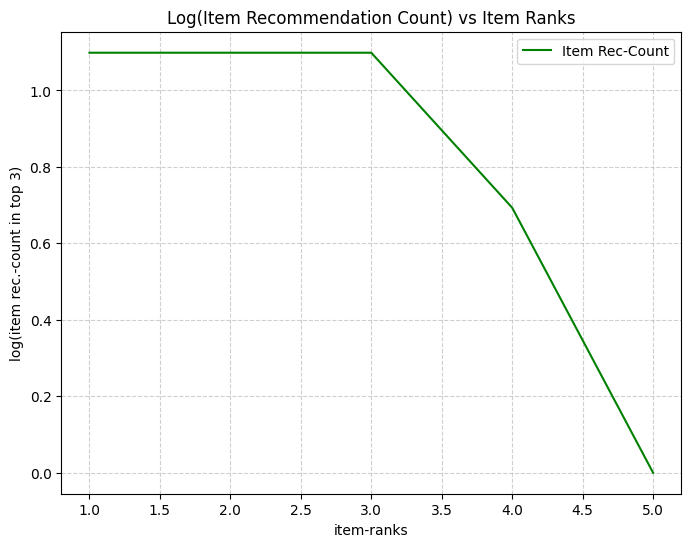

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def evaluate_recommendations(recommendations, top_n=100):
    """
    Evaluate a set of recommendations using the item recommendation count in the top-N list.

    Args:
        recommendations (list of lists): A list where each sublist contains recommended items for a user.
        top_n (int): The number of top recommendations to consider for each user.

    Returns:
        None. Displays the plot of log(item rec-count in top N) vs item ranks.
    """
    # Flatten the list of top-N recommendations
    top_n_items = [item for user_recs in recommendations for item in user_recs[:top_n]]
    print(f"Flattened top-{top_n} items: {top_n_items}")

    # Count how often each item appears in the top-N recommendations
    item_counts = Counter(top_n_items)
    print(f"Item counts: {item_counts}")

    # Sort items by count in descending order
    sorted_counts = np.array(sorted(item_counts.values(), reverse=True))
    print(f"Sorted counts: {sorted_counts}")

    # Generate ranks (1-based indexing)
    ranks = np.arange(1, len(sorted_counts) + 1)
    print(f"Ranks: {ranks}")

    # Plot the results
    plt.figure(figsize=(8, 6))
    plt.plot(ranks, np.log(sorted_counts), label="Item Rec-Count", color="green")
    plt.xlabel("item-ranks")
    plt.ylabel("log(item rec.-count in top {})".format(top_n))
    plt.title("Log(Item Recommendation Count) vs Item Ranks")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()
    plt.show()

# Example usage
if __name__ == "__main__":
    # Example recommendations (each sublist is a user's recommendations)
    example_recommendations = [
        [1, 2, 3, 4, 5],
        [2, 3, 4, 5, 6],
        [1, 3, 4, 6, 7],
        [1, 2, 5, 6, 8],
    ]

    print("Evaluating recommendations...")
    evaluate_recommendations(example_recommendations, top_n=3)
